In [1]:
import pandas as pd
import numpy as np

In [2]:
!pip install kaggle

In [7]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [8]:
!kaggle datasets download -d grassknoted/asl-alphabet

100% 1.02G/1.03G [00:33<00:00, 40.9MB/s]
100% 1.03G/1.03G [00:33<00:00, 32.4MB/s]


In [9]:
!unzip asl-alphabet

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

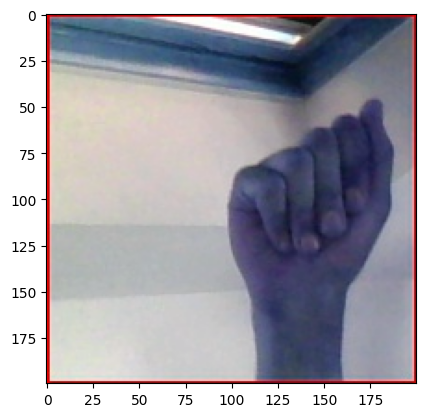

In [10]:
import matplotlib.pyplot as plt
import cv2
img=cv2.imread("/content/asl_alphabet_train/asl_alphabet_train/A/A1001.jpg")
plt.imshow(img)

In [11]:
train_path="/content/asl_alphabet_train/asl_alphabet_train"

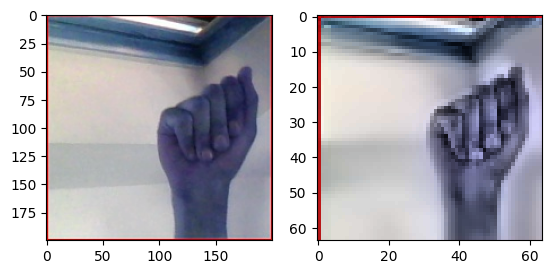

In [12]:
bgr_img = cv2.imread("/content/asl_alphabet_train/asl_alphabet_train/A/A1001.jpg")
# dsize
dsize = (64,64)
resized_image = cv2.resize(bgr_img,dsize)
# convert from BGR color-space to YCrCb
ycrcb_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YCrCb)
# create a CLAHE object
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# Now apply on the YCrCb image
ycrcb_img[:, :, 0] = clahe.apply(ycrcb_img[:, :, 0])
# convert back to BGR color-space from YCrCb
equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
# Denoise is done to remove unwanted noise to better perform
equalized_denoised_image = cv2.fastNlMeansDenoisingColored(equalized_img, None, 10, 10, 7, 21)
plt.subplot(121),plt.imshow(bgr_img)
plt.subplot(122),plt.imshow(equalized_denoised_image)
plt.show()

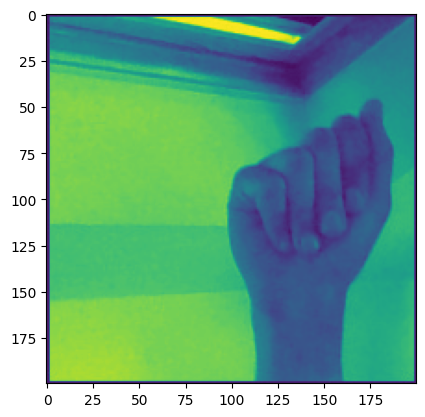

In [13]:
from PIL import Image

# Open the image
image = Image.open("/content/asl_alphabet_train/asl_alphabet_train/A/A1001.jpg")

# Convert the image to grayscale
grayscale_image = image.convert("L")

plt.imshow(grayscale_image)


In [14]:
import os
import tensorflow as tf
def preprocess_images(dataset_path):
    images_data = []
    images_label = []
    class_names = os.listdir(dataset_path)
    for class_name in class_names:
        images_path = dataset_path + '/' + class_name
        images = os.listdir(images_path)
        for image in images:
            image = Image.open(images_path + '/' + image)
            # dsize
            dsize = (64,64)
            #resize image
            resized_image = image.resize(dsize)
            grayscale_image = resized_image.convert("L")
            image_tensor = tf.convert_to_tensor(grayscale_image)
            images_data.append(image_tensor)
            images_label.append(class_name)
    images_data = np.array(images_data)
    images_label = np.array(images_label)
    return images_data, images_label

In [15]:
train_images,train_labels=preprocess_images(train_path)

space


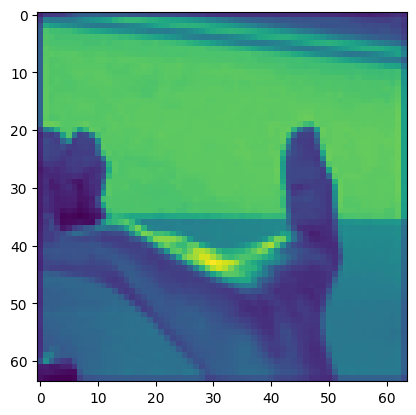

In [16]:
plt.imshow(train_images[0])
print(train_labels[0])

In [17]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(train_labels)
print(y)

[28 28 28 ... 16 16 16]


In [18]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(train_images,y,test_size=0.25,random_state=5)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(65250, 64, 64)
(65250,)
(21750, 64, 64)
(21750,)


In [19]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl
class_names=os.listdir(train_path)
class_num=len(class_names)
model = tf.keras.Sequential([
    tfl.Conv2D(filters=32, kernel_size=(3,3), activation='relu',input_shape=(64,64,1)),
    tfl.MaxPool2D(pool_size=(2,2)),
    tfl.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    tfl.BatchNormalization(axis=-1),
    tfl.Dropout(rate=0.3),


    tfl.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    tfl.MaxPool2D(pool_size=(2,2)),
    tfl.BatchNormalization(axis=-1),
    tfl.Dropout(rate=0.4),


    tfl.Flatten(),
    tfl.Dense(512,activation='relu'),
    tfl.BatchNormalization(),
    tfl.Dropout(rate=0.5),

    tfl.Dense(class_num, activation='softmax')

])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 29, 29, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 29, 29, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 32)        9

In [20]:
model.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history=model.fit(x=X_train,y=y_train,validation_data=(X_val,y_val),epochs=10)

Epoch 1/10
2040/2040 [==============================] - 33s 10ms/step - loss: 1.2856 - accuracy: 0.6240 - val_loss: 3.6095 - val_accuracy: 0.3545
Epoch 2/10
2040/2040 [==============================] - 19s 9ms/step - loss: 0.3782 - accuracy: 0.8721 - val_loss: 1.1479 - val_accuracy: 0.6872
Epoch 3/10
2040/2040 [==============================] - 19s 10ms/step - loss: 0.2426 - accuracy: 0.9164 - val_loss: 2.9663 - val_accuracy: 0.5465
Epoch 4/10
2040/2040 [==============================] - 18s 9ms/step - loss: 0.2284 - accuracy: 0.9236 - val_loss: 0.2663 - val_accuracy: 0.9099
Epoch 5/10
2040/2040 [==============================] - 18s 9ms/step - loss: 0.1667 - accuracy: 0.9429 - val_loss: 1.2355 - val_accuracy: 0.7599
Epoch 6/10
2040/2040 [==============================] - 19s 9ms/step - loss: 0.1507 - accuracy: 0.9489 - val_loss: 0.3965 - val_accuracy: 0.8961
Epoch 7/10
2040/2040 [==============================] - 18s 9ms/step - loss: 0.1390 - accuracy: 0.9533 - val_loss: 13.5663 - val

In [21]:
test_path="/content/asl_alphabet_test/asl_alphabet_test"

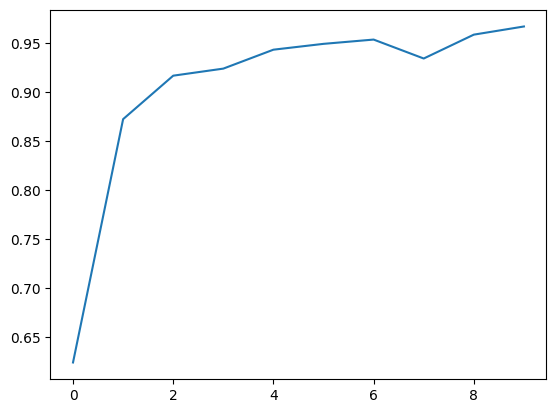

In [22]:
plt.plot(history.history["accuracy"])


In [24]:
test_images,test_labels=preprocess_images(train_path)
prediction=model.predict(test_images)

2719/2719 [==============================] - 6s 2ms/step
